In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_gen_module import moffat, sersic
from src.analysis_module import gaussian_weight, wiener_deconvolution
from scipy.ndimage import shift
import matplotlib as mpl

In [198]:
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

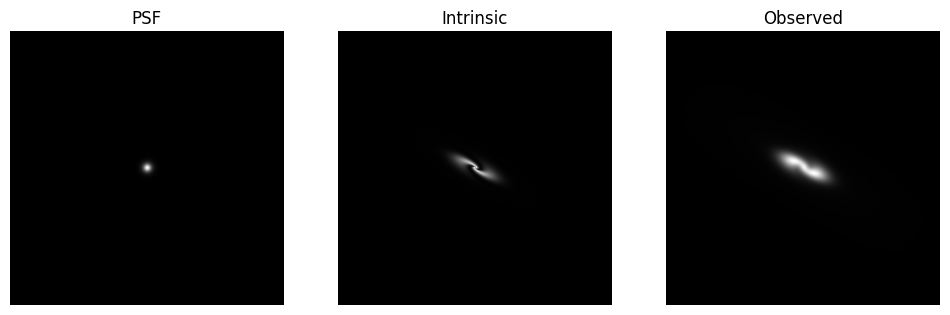

In [199]:
width= 400
height = 400

# Creating PSF and Galaxy images
image_psf = moffat(width, height, 3.5, 10)
image_intrinsic = sersic(width, height, height/2, width/2, k=1.5, n=4, inclination=np.radians(70), rotation=np.radians(30),  n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(12, 8))

im0 =axs[0].imshow(image_psf, extent=(0,width,0,height))
axs[0].set_title("PSF")

im1 = axs[1].imshow(image_intrinsic, extent=(0,width,0,height))
axs[1].set_title("Intrinsic")

im1 = axs[2].imshow(image, extent=(0,width,0,height))
axs[2].set_title("Observed")
plt.show()

In [200]:
weight = gaussian_weight(height, width, height/2, width/2, 15, 15)

true_F = np.sum(weight * image_intrinsic)
print(true_F)

weight_rescale = wiener_deconvolution(weight, image_psf, 0)

measured_F = np.sum(weight_rescale * image)
print(measured_F)

0.3392771508965992
0.3381341498123046


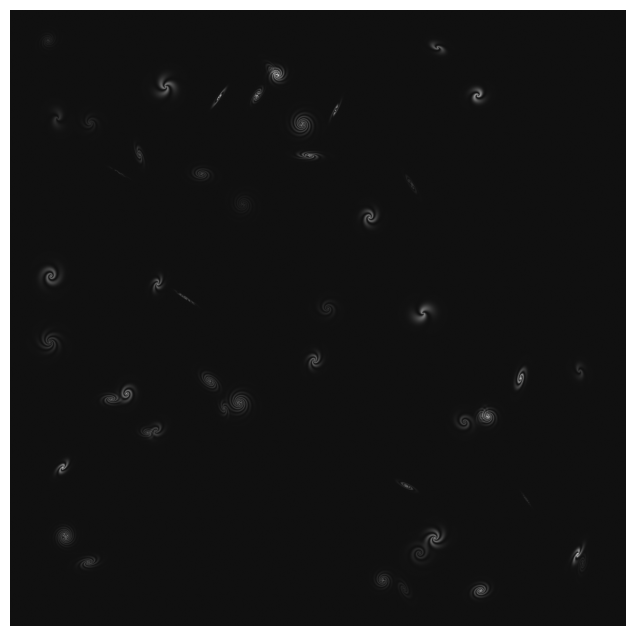

In [218]:
N_galaxies = 50
height = 1000
width = 1000
margin = 50
a = 8
b = 8

centers = []
true_F = []
image = np.zeros((height, width), dtype=float)
for _ in range(N_galaxies):
    xc = np.random.uniform(0 + margin, width - margin)
    yc = np.random.uniform(0 + margin, height - margin)
    k = np.random.uniform(1e-3, 1)
    n = np.random.uniform(0.2, 0.5)
    rotation = np.random.uniform(-np.pi / 2, np.pi / 2)
    inclination = np.random.uniform(0.1, np.pi / 2)
    n_arms = np.random.randint(2, 6)
    winding = np.random.uniform(1, 5)
    arm_width = np.random.uniform(0.001, 0.004)
    bulge_strength = np.random.uniform(0.5, 1)
    Rc = np.random.uniform(10, 15)
    galaxy_image = sersic(height, width, xc, yc, k, n, inclination=inclination, rotation=rotation, Rc=Rc, n_arms=n_arms,
                    winding=winding, bulge_strength=bulge_strength,
                    direction=np.random.choice([-1, 1])) * np.random.uniform(1, 10)
    centers.append((xc, yc))
    weight = gaussian_weight(height, width, xc, yc, a, b)

    true_F.append(np.sum(weight * galaxy_image))
    image += galaxy_image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

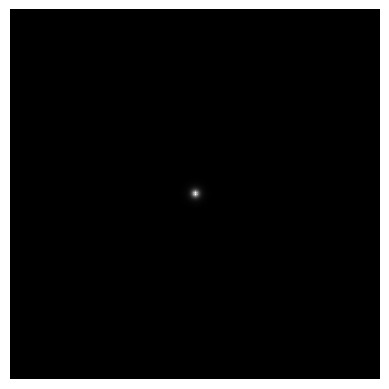

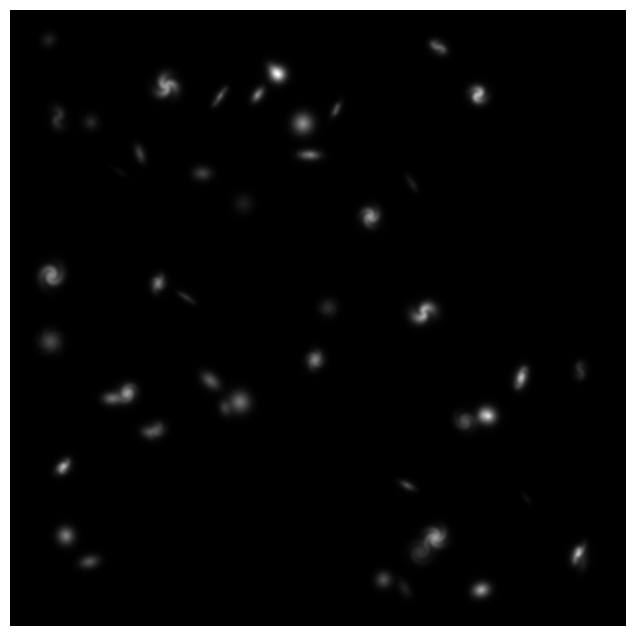

In [232]:
image_psf = moffat(400, 400, 2, 5, n_spikes=6, rotation=np.pi/3, spike_strength=0.2, spike_width=0.2, Rc=2)
image_psf /= image_psf.sum()
plt.imshow(image_psf)
plt.show()
plt.figure(figsize=(8, 8))
plt.imshow(fftconvolve(image, image_psf, mode='same')+np.random.random(size=image.shape)*0)
plt.show()

In [233]:
new_image = fftconvolve(image, image_psf, mode='same')
measured_F = []
weight = gaussian_weight(height, width, height/2, width/2, a, b)
weight_rescale = wiener_deconvolution(weight, image_psf, 0)
cy, cx = np.array(weight_rescale.shape) / 2
for i,(xc, yc) in enumerate(centers):
    # print(i, 'of the ', N_galaxies)
    translated = shift(weight_rescale, shift=(yc-cy, xc-cx), order=0, mode='constant', cval=0.0)

    measured_F.append(np.sum(translated * new_image))

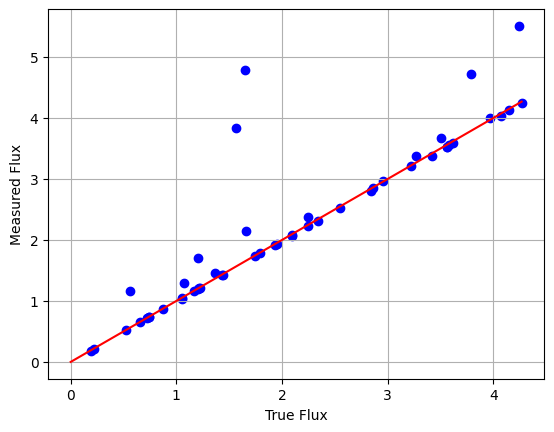

In [234]:
measured_F = np.array(measured_F)
true_F = np.array(true_F)
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    plt.scatter(true_F, measured_F, label='Measured', c='blue')
    plt.plot(np.linspace(0, max(true_F), 10),np.linspace(0, max(true_F), 10), c='red', label='True')

    plt.xlabel('True Flux')
    plt.ylabel('Measured Flux')
    plt.show()


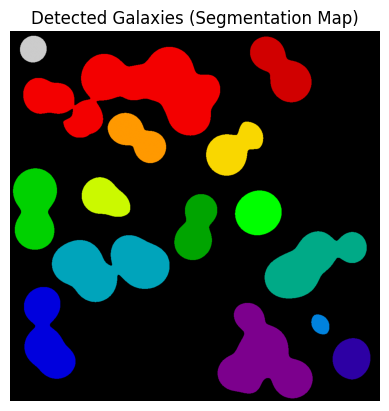

In [235]:
from photutils.segmentation import detect_threshold, detect_sources

# Detect background threshold
threshold = detect_threshold(new_image, nsigma=3.0)

# Create segmentation map (each galaxy gets a unique label)
segm = detect_sources(new_image, threshold, npixels=20)

plt.imshow(segm.data, origin='lower', cmap='nipy_spectral')
plt.title("Detected Galaxies (Segmentation Map)")
plt.show()

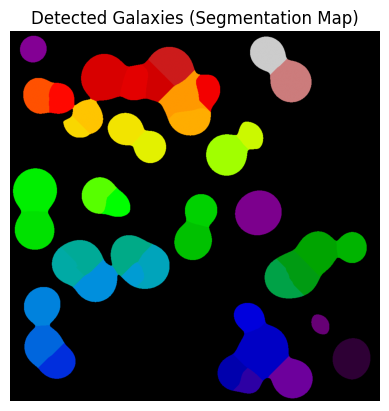

In [236]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(new_image, segm,
                               npixels=8, nlevels=32, contrast=0.001,
                               progress_bar=False)

plt.imshow(segm_deblend.data, origin='lower', cmap='nipy_spectral')
plt.title("Detected Galaxies (Segmentation Map)")
plt.show()

In [237]:
from photutils.centroids import centroid_com

centers_new = []
for label in segm_deblend.labels:
    mask = segm_deblend.data == label
    xc, yc = centroid_com(image * mask)
    centers_new.append((xc, yc))
    print(f"Galaxy {label}: center = ({xc:.1f}, {yc:.1f})")

Galaxy 1: center = (922.0, 113.5)
Galaxy 2: center = (837.5, 205.5)
Galaxy 3: center = (670.1, 507.0)
Galaxy 4: center = (61.5, 949.8)
Galaxy 5: center = (763.4, 57.0)
Galaxy 6: center = (639.6, 59.0)
Galaxy 7: center = (605.3, 73.8)
Galaxy 8: center = (682.2, 135.1)
Galaxy 9: center = (643.8, 226.6)
Galaxy 10: center = (127.4, 102.7)
Galaxy 11: center = (89.3, 145.0)
Galaxy 12: center = (85.1, 256.7)
Galaxy 13: center = (231.6, 315.4)
Galaxy 14: center = (348.3, 352.6)
Galaxy 15: center = (372.7, 362.5)
Galaxy 16: center = (164.5, 367.8)
Galaxy 17: center = (190.0, 376.9)
Galaxy 18: center = (324.2, 396.7)
Galaxy 19: center = (737.5, 330.3)
Galaxy 20: center = (773.0, 340.1)
Galaxy 21: center = (828.4, 401.5)
Galaxy 22: center = (924.4, 413.3)
Galaxy 23: center = (493.9, 430.5)
Galaxy 24: center = (515.0, 515.0)
Galaxy 25: center = (64.4, 460.4)
Galaxy 26: center = (66.0, 567.7)
Galaxy 27: center = (284.8, 531.9)
Galaxy 28: center = (239.2, 554.9)
Galaxy 29: center = (583.6, 663.0)
Ga

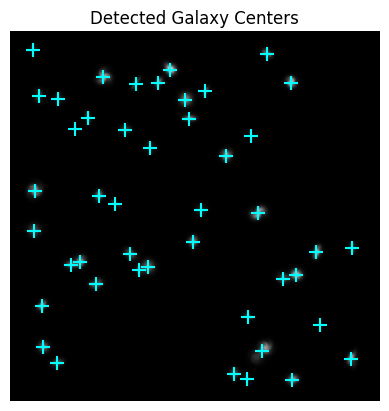

In [238]:
plt.imshow(new_image, origin='lower', cmap='gray')
for (xc, yc) in centers_new:
    plt.scatter(xc, yc, color='cyan', marker='+', s=100)
plt.title("Detected Galaxy Centers")
plt.show()

In [239]:
measured_F_new = []
weight = gaussian_weight(height, width, height/2, width/2, a, b)
weight_rescale = wiener_deconvolution(weight, image_psf, 0)
cy, cx = np.array(weight_rescale.shape) / 2
for i,(xc, yc) in enumerate(centers_new):
    # print(i, 'of the ', N_galaxies)
    translated = shift(weight_rescale, shift=(yc-cy, xc-cx), order=0, mode='constant', cval=0.0)

    measured_F_new.append(np.sum(translated * new_image))

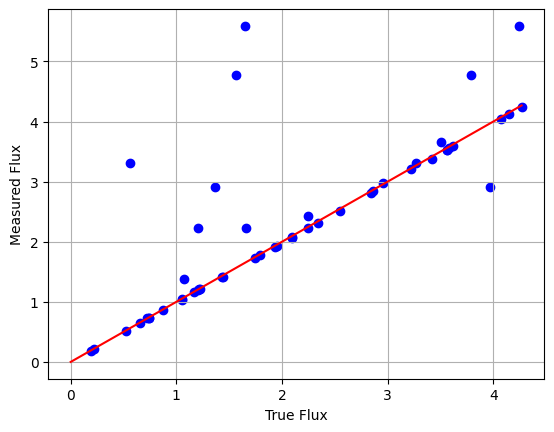

In [240]:
from scipy.spatial import cKDTree

tree = cKDTree(centers_new)
_, indices = tree.query(centers, k=1)

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    for i in range(len(centers)):
        plt.scatter(true_F[i], measured_F_new[indices[i]], label='Measured', c='blue')
    plt.plot(np.linspace(0, max(true_F), 10), np.linspace(0, max(true_F), 10), c='red', label='True')
    plt.xlabel('True Flux')
    plt.ylabel('Measured Flux')
    plt.show()

Text(0.5, 1.0, 'Simulated image')

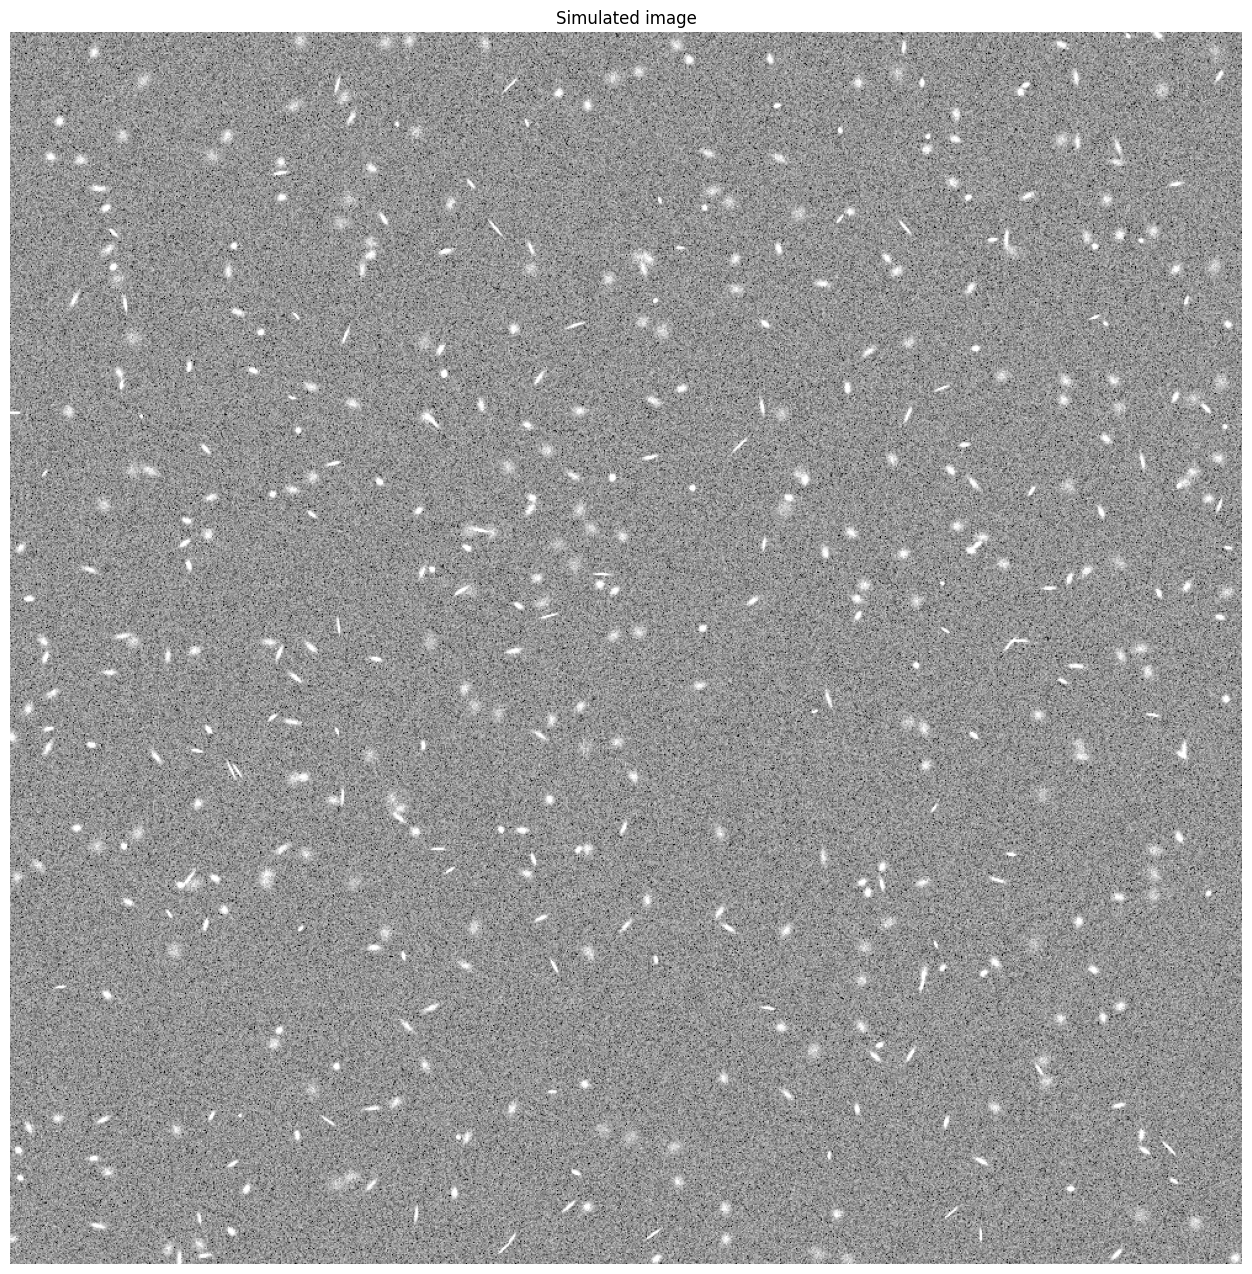

In [246]:
from astropy.visualization import simple_norm
from photutils.datasets import (make_model_image, make_model_params,
                                make_noise_image)
from photutils.psf import GaussianPSF

model = GaussianPSF()
shape = (1000, 1000)
n_sources = 500
params = make_model_params(shape, n_sources, x_name='x_0',
                           y_name='y_0', min_separation=5,
                           flux=(400, 500), x_fwhm=(1, 10),
                           y_fwhm=(1, 10), theta=(0, 90), seed=123)
model_shape = (25, 25)
data = make_model_image(shape, model, params, model_shape=model_shape,
                        x_name='x_0', y_name='y_0')

noise = make_noise_image(shape, distribution='gaussian', mean=3,
                         stddev=2, seed=123)
data += noise

fig, ax = plt.subplots(figsize=(16, 16))
norm = simple_norm(data, 'sqrt', percent=99)
ax.imshow(data, norm=norm, origin='lower')
ax.set_title('Simulated image')